In [2]:
import numpy as np
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt

In [3]:
def im2col(input_matrix, kernel_height, kernel_width, stride, padding, dilation):
    num_inputs, in_channels, input_height, input_width = input_matrix.shape

    output_height = (input_height + 2 * padding[0] - dilation[0] * (kernel_height - 1) - 1) // stride[0] + 1
    output_width = (input_width + 2 * padding[1] - dilation[1] * (kernel_width - 1) - 1) // stride[1] + 1

    padded_input = np.pad(input_matrix, ((0, 0), (0, 0), (padding[0], padding[0]), (padding[1], padding[1])), mode='constant')
    
    column_matrix = np.zeros((num_inputs, in_channels, kernel_height, kernel_width, output_height, output_width))

    for h in range(kernel_height):
        for w in range(kernel_width):
            column_matrix[:, :, h, w, :, :] = padded_input[:, :, h * dilation[0]:h * dilation[0] + output_height * stride[0]:stride[0],
                                                       w * dilation[1]:w * dilation[1] + output_width * stride[1]:stride[1]]

    column_matrix = column_matrix.transpose(0, 4, 5, 1, 2, 3).reshape(num_inputs * output_height * output_width, -1)
    return column_matrix

In [4]:
def conv2d(input_matrix, kernel, stride=(1, 1), padding=(0, 0), dilation=(1, 1)):
    num_inputs, in_channels, input_height, input_width = input_matrix.shape
    out_channels, not_needed, kernel_height, kernel_width = kernel.shape

    output_height = (input_height + 2 * padding[0] - dilation[0] * (kernel_height - 1) - 1) // stride[0] + 1
    output_width = (input_width + 2 * padding[1] - dilation[1] * (kernel_width - 1) - 1) // stride[1] + 1

    col_matrix = im2col(input_matrix, kernel_height, kernel_width, stride, padding, dilation)
    kernel_matrix = kernel.reshape(out_channels, -1)

    output = np.dot(col_matrix, kernel_matrix.T)
    output = output.reshape(num_inputs, output_height, output_width, out_channels).transpose(0, 3, 1, 2)

    return output

Number of output mismatches: 0 out of 1000 trials


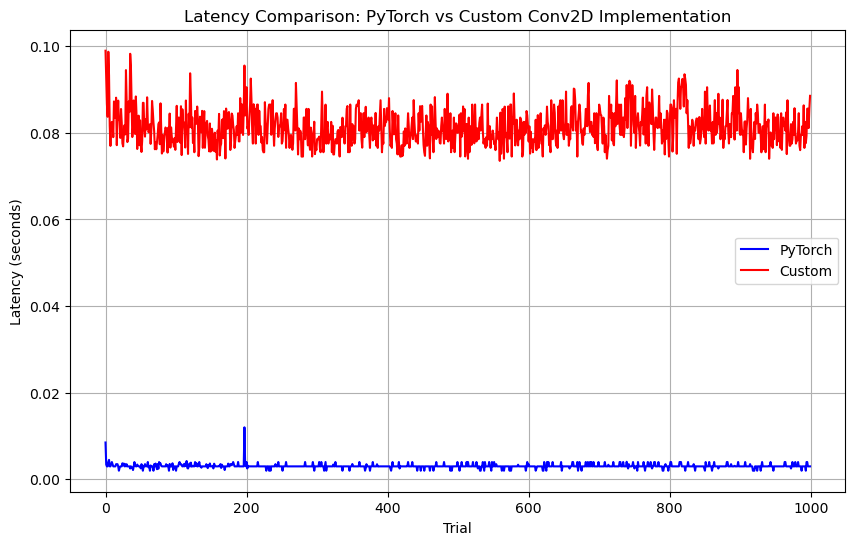

In [7]:
def measure_latency():

    input_matrix = np.random.randn(20, 16, 50, 100).astype(np.float32)
    kernel = np.random.randn(33, 16, 3, 5).astype(np.float32)

    input_tensor = torch.tensor(input_matrix)
    kernel_tensor = torch.tensor(kernel)

    conv2d_layer = nn.Conv2d(in_channels=16, out_channels=33, kernel_size=(3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1), bias=False)
    conv2d_layer.weight = torch.nn.Parameter(kernel_tensor)

    pytorch_times = []
    custom_times = []
    output_comparisons = []

    # Run 1000 latency trials
    for _ in range(1000):

        start_time = time.time()
        with torch.no_grad():
            pytorch_output = conv2d_layer(input_tensor)
        pytorch_times.append(time.time() - start_time)

        start_time = time.time()
        custom_output = conv2d(input_matrix, kernel, stride=(2, 1), padding=(4, 2), dilation=(3, 1))
        custom_times.append(time.time() - start_time)

        custom_output_tensor = torch.tensor(custom_output).float()

        are_outputs_close = torch.allclose(pytorch_output, custom_output_tensor, atol=1e-4)
        output_comparisons.append(are_outputs_close)

    print(f"Number of output mismatches: {output_comparisons.count(False)} out of 1000 trials")

    return pytorch_times, custom_times

def plot_latency_comparison(pytorch_times, custom_times):
    plt.figure(figsize=(10, 6))

    plt.plot(pytorch_times, label="PyTorch", color='blue')
    plt.plot(custom_times, label="Custom", color='red')

    plt.xlabel('Trial')
    plt.ylabel('Latency (seconds)')
    plt.title('Latency Comparison: PyTorch vs Custom Conv2D Implementation')
    plt.legend()
    plt.grid(True)

    plt.show()

def main():
    pytorch_times, custom_times = measure_latency()
    plot_latency_comparison(pytorch_times, custom_times)

main()